In [1]:
# prompt: connect with drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/pytorch_openpose_body_25-main
class_index = {'pos' : 1, 'neg': 0}

input_base_path = r'train_latest'
output_base_path = r'traincsvopenpose'

/content/drive/MyDrive/pytorch_openpose_body_25-main


In [3]:
import cv2
import torch
import time
import numpy as np
import pandas as pd
import os
from openpose_pytorch import torch_openpose
from google.colab.patches import cv2_imshow
try:
    os.mkdir(output_base_path)
except Exception as e:
    print("Folder already created")

input_folders = os.listdir(input_base_path)
print(input_folders)

Folder already created
['pos', 'neg']


In [4]:
tp = torch_openpose.torch_openpose('body_25')
num_bf = 70

In [5]:
import math

def calculate_angle(x1, y1, x2, y2):
    #Given A(x1,y1) and B(x2,y2), calculate angle of BA with respect to the positive x-axis
    # Vector BA
    dx = x1 - x2
    dy = y1 - y2
    # Angle of vector BA with respect to the positive x-axis
    angle_ba = math.atan2(dy, dx)
    return angle_ba


logging has started
Folder already created
Processing the images for the behavior:  pos
Total images:  4


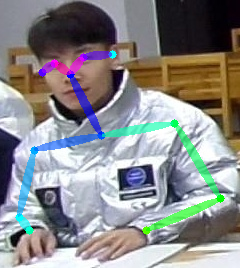

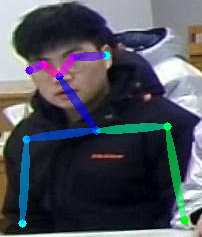

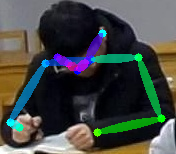

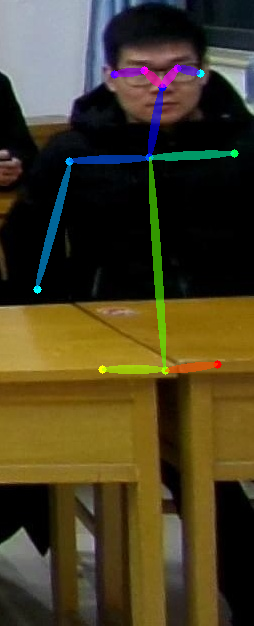

Folder already created
Processing the images for the behavior:  neg
Total images:  4


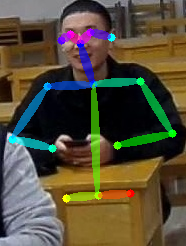

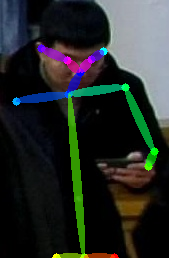

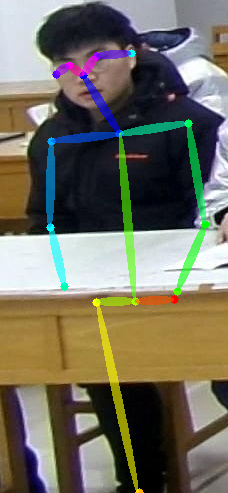

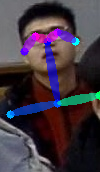

Runtime of the program is 53.442192792892456


In [14]:
start = time.time()
print("logging has started")

for folder in input_folders:
    flag_break = False
    folder_path = os.path.join(input_base_path, folder)
    images_list = os.listdir(folder_path)

    train_file_path = os.path.join(output_base_path, folder)
    try:
        os.mkdir(train_file_path)
    except Exception as e:
        print("Folder already created")
    print("Processing the images for the behavior: ", folder)
    print("Total images: ", len(images_list))
    iteration_ = 0
    for images in images_list:
        iteration_ += 1
        img_path = os.path.join(folder_path, images)
        img = cv2.imread(img_path)
        image_width = img.shape[1]
        image_height = img.shape[0]
        #img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #cv2_imshow(img)
        poses = tp(img)
        #img_in = util.draw_bodypose(img, poses,'body_25')
        #cv2_imshow(img_in)
        input_features = np.ones((1, num_bf))*(1e-6)
        iter_features = 0
        if poses:
          #10 point after apply OpenPose -> 20 first feature
          for i in [0, 1, 2, 3, 4, 5, 6, 7, 15, 16]:
            if len(poses[0]) > i:
              normalized_x = poses[0][i][0] / image_width
              input_features[0][iter_features] = normalized_x
              iter_features += 1
              normalized_y = poses[0][i][1] / image_height
              input_features[0][iter_features] = normalized_y
              iter_features += 1
          #45 feature distance between each point
          for i in range(10):
            for j in range(i+1,10):
              distance = math.sqrt((input_features[0][2*i] - input_features[0][2*j])**2 + (input_features[0][2*i+1] - input_features[0][2*j+1])**2)
              input_features[0][iter_features] = distance
              iter_features = iter_features + 1
          #calculate angle of 5 last feature
          #point 0 with point 1
          angle_01 = calculate_angle(input_features[0][0], input_features[0][1], input_features[0][2], input_features[0][3])
          angle_12h = math.pi / 2
          angle_clockwise_01 = angle_01 - angle_12h
          if angle_clockwise_01 < 0:
            angle_clockwise_01 += 2 * math.pi
          input_features[0][iter_features] = angle_clockwise_01
          iter_features += 1
          #point 2 with point 3
          angle_23 = calculate_angle(input_features[0][4], input_features[0][5], input_features[0][6], input_features[0][7])
          angle_9h = math.pi
          angle_anticlockwise_23 = angle_9h - angle_23
          if angle_anticlockwise_23 < 0:
            angle_anticlockwise_23 += 2 * math.pi
          input_features[0][iter_features] = angle_anticlockwise_23
          iter_features += 1
          #point 3 with point 4
          angle_34 = calculate_angle(input_features[0][6], input_features[0][7], input_features[0][8], input_features[0][9])
          angle_12h = math.pi / 2
          angle_clockwise_34 = angle_34 - angle_34 - angle_12h
          if angle_clockwise_34 < 0:
            angle_clockwise_34 += 2 * math.pi
          input_features[0][iter_features] = angle_clockwise_34
          iter_features += 1
          #point 5 with point 6
          angle_56 = calculate_angle(input_features[0][10], input_features[0][11], input_features[0][12], input_features[0][13])
          angle_3h = 0
          angle_anticlockwise_56 = angle_56 - angle_3h
          if angle_anticlockwise_56 < 0:
            angle_anticlockwise_56 += 2 * math.pi
          input_features[0][iter_features] = angle_anticlockwise_56
          iter_features += 1
          #point 6 with point 7
          angle_67 = calculate_angle(input_features[0][12], input_features[0][13], input_features[0][14], input_features[0][15])
          angle_12h = math.pi / 2
          angle_clockwise_67 = angle_12h - angle_67
          if angle_clockwise_67 < 0:
            angle_clockwise_67 += 2 * math.pi
          input_features[0][iter_features] = angle_clockwise_67
          iter_features += 1
          #print(input_features)
        #creating the csv of every person
        df = pd.DataFrame(input_features)
        df.to_csv(train_file_path + r'/' + images.split('.')[0] + '.csv', sep=',',index=False, header=False)

        if iteration_ != 0 and iteration_ % 40 == 0:
            print("\tImage Processed: ",iteration_)
end = time.time()
print(f"Runtime of the program is {end - start}")